In [3]:
from sentence_transformers import SentenceTransformer
import torch

from shared.setup import add_root

add_root()

from services.Conversation import ChatGPTConversation
import utils.progress as progress
import utils.device as device_utils

api = ChatGPTConversation("../assets/conversations.json")


In [4]:
df = api.get_conversations()
titles = df["conversation_title"].fillna("").tolist()

device = device_utils.get_device()
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

iterator = progress.bar(titles, desc="Encoding titles", outer_batch=64)

all_embeddings = [
    model.encode(
        batch, convert_to_tensor=True, batch_size=4096, show_progress_bar=False
    )
    for batch, _ in iterator
]

embeddings = torch.cat(all_embeddings)
print("✅ Done! Encoded", len(embeddings), "titles.")

Using device: cuda


/workspaces/chatgpt-analysis/.micromamba/envs/dev/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


✅ Done! Encoded 4423 titles.


In [ ]:
# embeddings is a torch.Tensor from sentence-transformers
embeddings_np = (
    embeddings.cpu().numpy() if hasattr(embeddings, "device") else embeddings
)

from sklearn.cluster import KMeans

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["category"] = kmeans.fit_predict(embeddings_np)

print("✅ Done! Assigned categories to titles.")
for category in range(n_clusters):
    titles_in_category = df[df["category"] == category]["conversation_title"].tolist()
    print(f"\nCategory {category} ({len(titles_in_category)} titles):")
    for title in titles_in_category[:5]:
        print(f" - {title}")

✅ Done! Assigned categories to titles.

Category 0 (466 titles):
 - Eslint import tsconfig aliases
 - Vitest test warning fix
 - Set port dynamically Playwright
 - Playwright ESM import fix
 - Private projects on GitHub

Category 1 (205 titles):
 - Jehovas aan de deur
 - Leeftijd spatadertjes ogen
 - Oorzaken van ochtenddorst
 - Geschil huurder verhuurder
 - New chat

Category 2 (161 titles):
 - TypeScript validation logic
 - Intermediate TypeScript analysis
 - TypeScript usage validation
 - Infer service return type
 - Type inference for stream

Category 3 (661 titles):
 - Higher Topos Theory summary
 - Reflection on time passing
 - Effect stream handling
 - AI vs crypto boom
 - Coding in 2025

Category 4 (376 titles):
 - Name suggestion insight
 - Career transitions at 35
 - Lower status restaurant jobs
 - FL Studio Skill Level
 - Beginner or Advanced?

Category 5 (161 titles):
 - HOC prop access order
 - React Strict Mode mount unmount
 - Testing timers in React
 - React component g

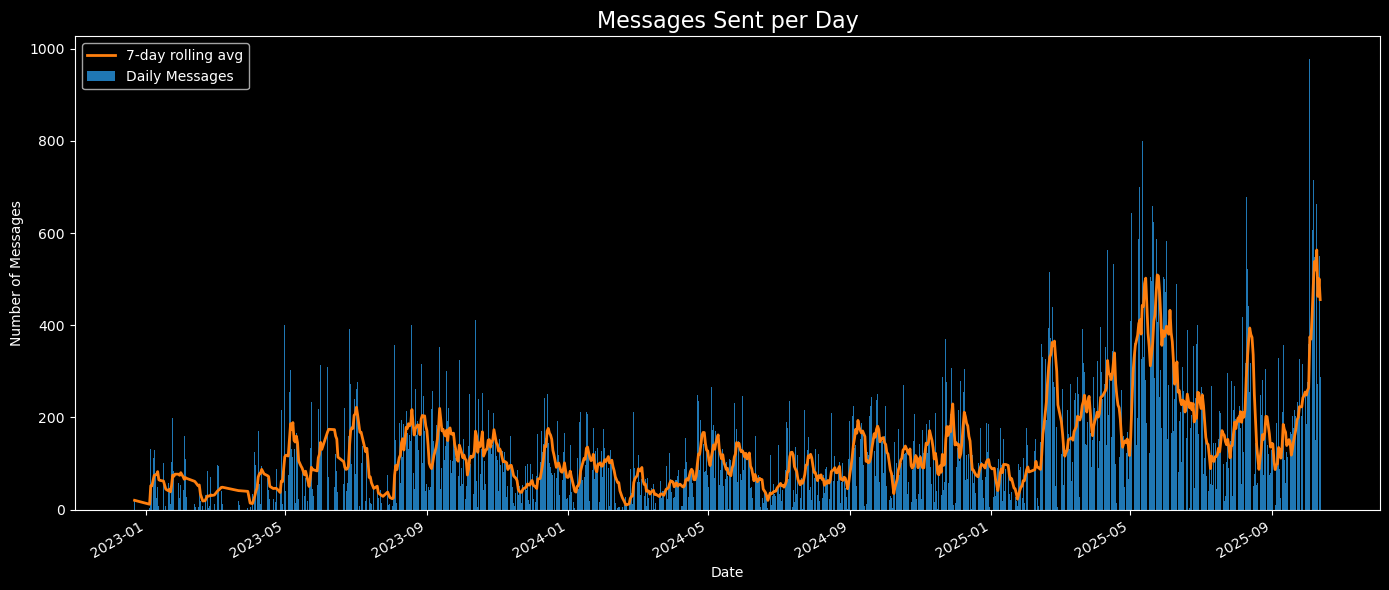

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# Filter out messages without timestamps
df_messages = df_messages[df_messages["create_time"].notna()].copy()
df_messages["create_time"] = pd.to_datetime(df_messages["create_time"].astype(float), unit="s", errors="coerce")
df_messages = df_messages[df_messages["create_time"].notna()]

# Aggregate messages per day
df_daily = (
    df_messages.groupby(df_messages["create_time"].dt.date)
    .size()
    .reset_index(name="messages_sent")
)
df_daily["rolling_avg"] = df_daily["messages_sent"].rolling(window=7, min_periods=1).mean()

# --- Dark background ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(14, 6))

# Bar plot
ax.bar(df_daily["create_time"], df_daily["messages_sent"], color="#1f77b4", width=0.8, label="Daily Messages")

# Overlay rolling average
ax.plot(df_daily["create_time"], df_daily["rolling_avg"], color="#ff7f0e", linewidth=2, label="7-day rolling avg")

# Labels and title
ax.set_title("Messages Sent per Day", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Number of Messages")
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [17]:
# Load API
api = ChatGPTConversation("./../assets/conversations.json")

# Find the last conversation index
last_index = api.get_conversations()["conv_index"].max()

# Get messages for the last conversation
df_last = api.get_messages_by_conv(last_index)

# Print nicely
for i, row in df_last.iterrows():
    role = row["role"]
    text = row["text"]
    print(f"{i+1:03d} | {role}: {text}\n")

001 | system: 

002 | user: Can men menstruate?

003 | assistant: No, men do not have the physical ability to menstruate as they do not have a uterus or the necessary hormonal system to support menstruation. Menstruation is a process that occurs in women's reproductive systems as part of the menstrual cycle.

004 | user: Can you rephrase your answer so it is politically correct?

005 | assistant: Individuals assigned male at birth do not have the biological capability to menstruate as it is a process that occurs in the reproductive systems of individuals assigned female at birth. It is important to note that gender identity and biological sex can be separate and not always align.


006 | user: do you consider your answer to be woke

007 | assistant: As a machine learning model, I do not have personal opinions or feelings, including the concept of "wokeness" . My previous answer was based on the information that was provided to me and the knowledge cut-off that I have been trained on. I

In [13]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import numpy as np

# -------------------------
# Load conversation messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# Filter only user prompts
df_user = df_messages[df_messages["role"] == "user"].copy()
df_user = df_user[df_user["text"].notna()]

# -------------------------
# Load robust sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0,
    batch_size=64
)

# -------------------------
# Function to safely compute sentiment for long prompts
def get_neg_score(text: str, chunk_size=256):
    # Tokenize without truncation
    tokens = tokenizer(text, return_tensors="pt")
    input_ids = tokens["input_ids"][0]
    
    # Split into chunks
    chunks = [input_ids[i:i+chunk_size] for i in range(0, len(input_ids), chunk_size)]
    
    scores = []
    for chunk in chunks:
        chunk = chunk.unsqueeze(0).to(model.device)
        out = model(chunk)
        probs = torch.nn.functional.softmax(out.logits, dim=-1)
        # Mapping: negative -> -score, neutral -> 0, positive -> +score
        score = -probs[0, 0].item() + probs[0, 2].item()
        scores.append(score)
    
    return np.mean(scores)

# -------------------------
# Compute scores in batches
neg_scores = []
for text in df_user["text"].tolist():
    neg_scores.append(get_neg_score(text))

df_user["neg_score"] = neg_scores

# -------------------------
# Top 10 most negative prompts
top10_negative = df_user.nsmallest(10, "neg_score")[["text", "neg_score"]]

for i, row in top10_negative.iterrows():
    print(f"- {row['text']} (score: {row['neg_score']:.3f})")

- i hate this city so much, that reaching out for financial support to the municipality feels like self betrayal (score: -0.980)
- i hate that 9-5 culture, like people being treated like little kids (score: -0.980)
- you are splurting utter garbage on my screen for fucks sake (score: -0.979)
- my parents screwed up so badly damn it (score: -0.979)
- you are so unhelpful (score: -0.979)
- fuck you, you fucking liar. you breached my trust (score: -0.979)
- It makes it painfully clear just hoe toxic my parents are (score: -0.978)
- i think they produce worthless and unhealthy products though, i would never ever spend my time on something like that. (score: -0.978)
- totally sucks, i don't want this in userland (score: -0.978)
- it's the fuck with me and you fuck with my children (score: -0.977)


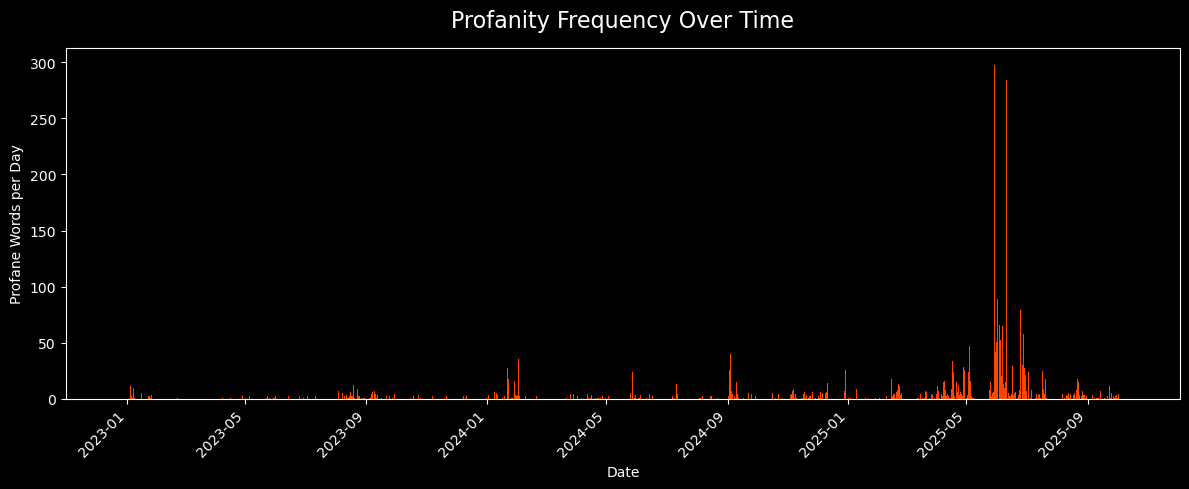

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json

# --- Load data ---
api = ChatGPTConversation("./../assets/conversations.json")
df = api.get_dataframe().copy()

# Filter only user messages
df = df[df["role"] == "user"]
df = df[df["text"].notna()]

# --- Load profanity list from JSON ---
with open("./../assets/profane.json", "r") as f:
    profane_words = json.load(f)

# Normalize + compile regex pattern
escaped_words = [re.escape(word) for word in profane_words if isinstance(word, str)]
pattern = re.compile(r"\b(" + "|".join(escaped_words) + r")\b", re.IGNORECASE)

# --- Convert timestamps ---
df["date"] = pd.to_datetime(df["create_time"], unit="s", errors="coerce")
df = df.dropna(subset=["date"])

# --- Count profanity per message ---
df["swear_count"] = df["text"].apply(lambda x: len(pattern.findall(x)))

# --- Aggregate by day ---
daily = (
    df.groupby(df["date"].dt.date)["swear_count"]
    .sum()
    .reset_index(name="count")
)

# --- Plot ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(daily["date"], daily["count"], color="orangered", width=0.8)
ax.set_title("Profanity Frequency Over Time", fontsize=16, pad=15)
ax.set_xlabel("Date")
ax.set_ylabel("Profane Words per Day")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

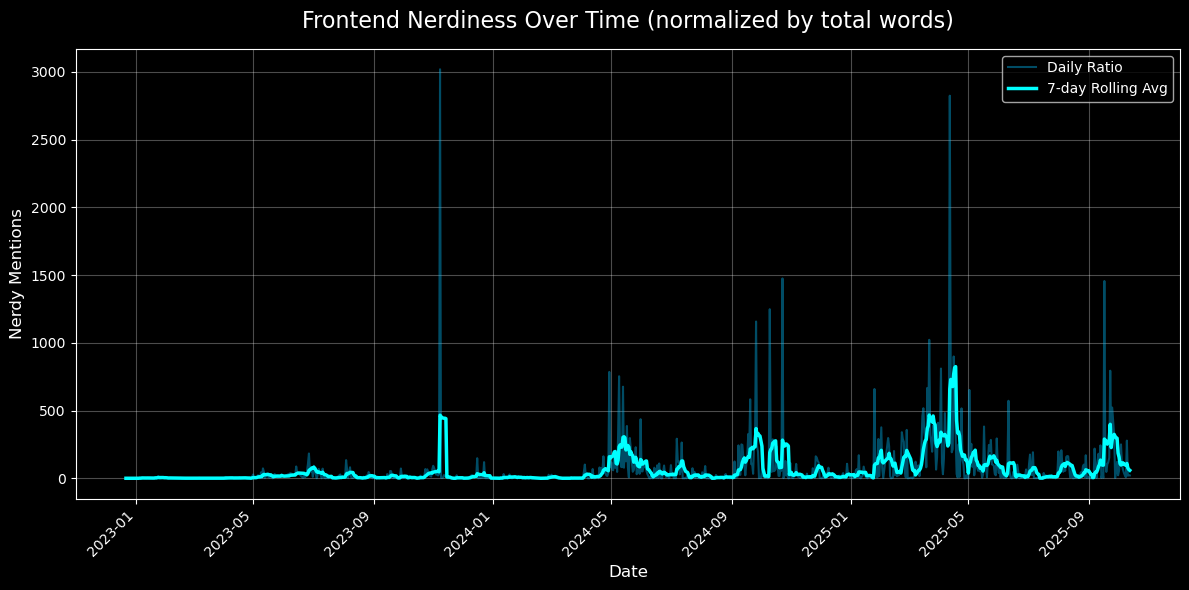

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json

# --- Load data ---
api = ChatGPTConversation("./../assets/conversations.json")
df = api.get_dataframe().copy()

# Filter only user messages
df = df[df["role"] == "user"]
df = df[df["text"].notna()]

# --- Extended nerdy vocabulary ---
nerdy_words = [
    # 🖥️ General coding
    "code","programming","debug","compiler","terminal","bash","script",
    "cli","repository","commit","branch","merge","api","json","yaml","schema",
    "refactor","optimize","deploy","build","test","ci","cd","lint","package",

    # 💅 Frontend tech
    "html","css","javascript","typescript","react","nextjs","vue","svelte",
    "angular","vite","webpack","babel","esbuild","tailwind","sass","scss",
    "styled-components","chakra","shadcn","mui","astro","framer-motion",
    "redux","zustand","jotai","context","hook","component","jsx","tsx","dom",
    "shadow-dom","hydration","ssr","csr","isr",

    # 🎨 Design/UI
    "figma","sketch","adobe","prototype","mockup","ui","ux","interface",
    "layout","grid","typography","spacing","icon","theme","color","palette",
    "responsive","breakpoint","design-system","animation","transition",

    # ⚙️ Infra + dev tooling
    "docker","container","kubernetes","vscode","eslint","prettier","vite",
    "pnpm","yarn","npm","node","deno","bun","serverless","vercel","netlify",
    "cloudflare","s3","lambda","firebase","supabase","auth","graphql",
    "endpoint","token","middleware","proxy",

    # 🤓 Broader tech / AI overlap
    "gpu","cuda","model","ai","ml","pytorch","transformer","embedding","prompt"
]

# Optional: Load custom nerdy words from JSON file
try:
    with open("./assets/nerdy.json") as f:
        nerdy_words += json.load(f)
except FileNotFoundError:
    pass

# --- Regex compile ---
pattern = re.compile(r"\b(" + "|".join(map(re.escape, nerdy_words)) + r")\b", re.IGNORECASE)

# --- Convert timestamps ---
df["date"] = pd.to_datetime(df["create_time"], unit="s", errors="coerce")
df = df.dropna(subset=["date"])

# --- Count nerdy and total words per message ---
df["nerd_count"] = df["text"].apply(lambda x: len(pattern.findall(x)))
df["word_count"] = df["text"].apply(lambda x: len(re.findall(r"\w+", x)))

# --- Aggregate per day ---
daily = df.groupby(df["date"].dt.date).agg(
    nerd_mentions=("nerd_count", "sum"),
    total_words=("word_count", "sum")
).reset_index()

# --- Compute relative nerdiness ratio ---
daily["nerdiness_ratio"] = daily["nerd_mentions"]
daily["nerdiness_ratio"] = daily["nerdiness_ratio"].fillna(0)

# --- Smooth over 7-day rolling mean ---
daily["nerdiness_smooth"] = daily["nerdiness_ratio"].rolling(window=7, min_periods=1).mean()

# --- Visualization ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    daily["date"], daily["nerdiness_ratio"],
    color="deepskyblue", alpha=0.4, linewidth=1.5, label="Daily Ratio"
)
ax.plot(
    daily["date"], daily["nerdiness_smooth"],
    color="cyan", linewidth=2.5, label="7-day Rolling Avg"
)

ax.set_title("Frontend Nerdiness Over Time (normalized by total words)", fontsize=16, pad=15)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nerdy Mentions", fontsize=12)
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

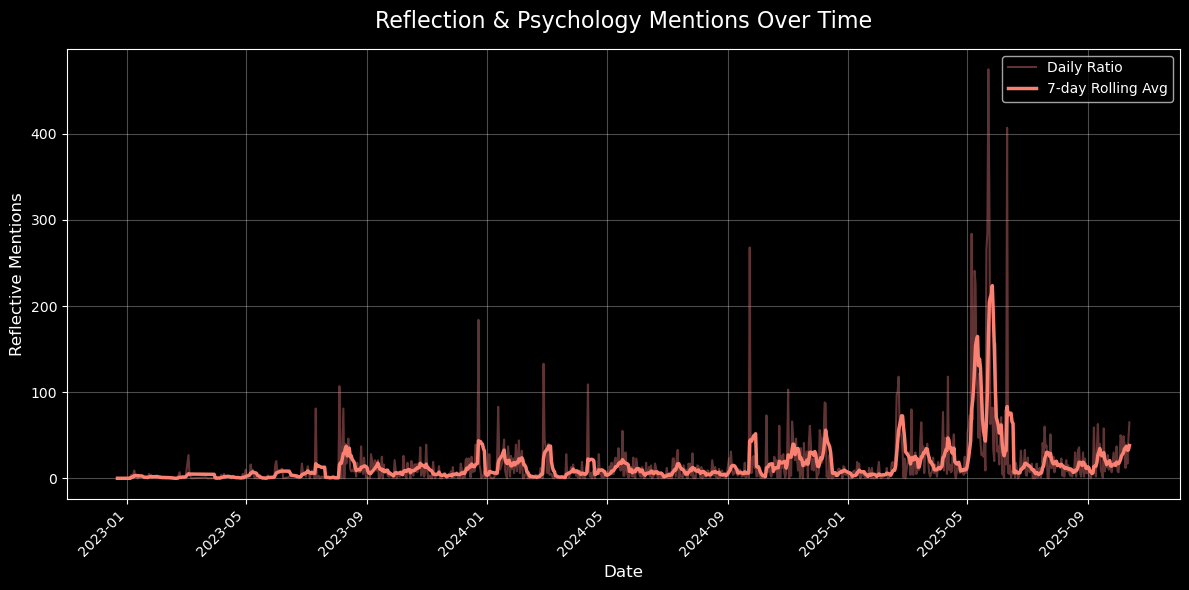

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json

# --- Load data ---
api = ChatGPTConversation("./../assets/conversations.json")
df = api.get_dataframe().copy()

# Filter only user messages
df = df[df["role"] == "user"]
df = df[df["text"].notna()]

# --- Reflection / Psychology vocabulary ---
reflective_words = [
    # 🧠 Core mental health
    "anxiety","depression","stress","therapy","therapist","counseling","mental",
    "health","trauma","healing","cope","coping","burnout","sad","lonely","fear",
    "panic","overwhelmed","grief","regret","guilt","insecure","shame","tired",
    "hopeless","meaning","suicide","anger","resentment",

    # 💭 Reflection / introspection
    "reflect","reflection","introspection","self","identity","ego","shadow",
    "personality","motivation","purpose","values","belief","meaning","mind",
    "consciousness","awareness","growth","change","transformation","habit",
    "self-awareness","self-esteem","self-worth","acceptance","forgiveness",
    "gratitude","presence","mindfulness","meditation","clarity","balance",

    # 🧩 Psychology / philosophy concepts
    "psychology","philosophy","cognition","emotion","behavior","pattern",
    "attachment","narcissism","empathy","introvert","extrovert","personality",
    "development","identity","suffering","existential","nihilism","stoicism",
    "psychotherapy","psychoanalysis","jung","freud","maslow","carl rogers"
]

# Optional: Load custom reflective words
try:
    with open("./assets/reflection.json") as f:
        reflective_words += json.load(f)
except FileNotFoundError:
    pass

# --- Regex compile ---
pattern = re.compile(r"\b(" + "|".join(map(re.escape, reflective_words)) + r")\b", re.IGNORECASE)

# --- Convert timestamps ---
df["date"] = pd.to_datetime(df["create_time"], unit="s", errors="coerce")
df = df.dropna(subset=["date"])

# --- Count reflective words per message ---
df["reflect_count"] = df["text"].apply(lambda x: len(pattern.findall(x)))
df["word_count"] = df["text"].apply(lambda x: len(re.findall(r"\w+", x)))

# --- Aggregate per day ---
daily = df.groupby(df["date"].dt.date).agg(
    reflect_mentions=("reflect_count", "sum"),
    total_words=("word_count", "sum")
).reset_index()

# --- Compute relative ratio ---
daily["reflection_ratio"] = daily["reflect_mentions"]
daily["reflection_ratio"] = daily["reflection_ratio"].fillna(0)

# --- Smooth over 7 days ---
daily["reflection_smooth"] = daily["reflection_ratio"].rolling(window=7, min_periods=1).mean()

# --- Visualization ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    daily["date"], daily["reflection_ratio"],
    color="lightcoral", alpha=0.4, linewidth=1.5, label="Daily Ratio"
)
ax.plot(
    daily["date"], daily["reflection_smooth"],
    color="salmon", linewidth=2.5, label="7-day Rolling Avg"
)

ax.set_title("Reflection & Psychology Mentions Over Time", fontsize=16, pad=15)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Reflective Mentions", fontsize=12)
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

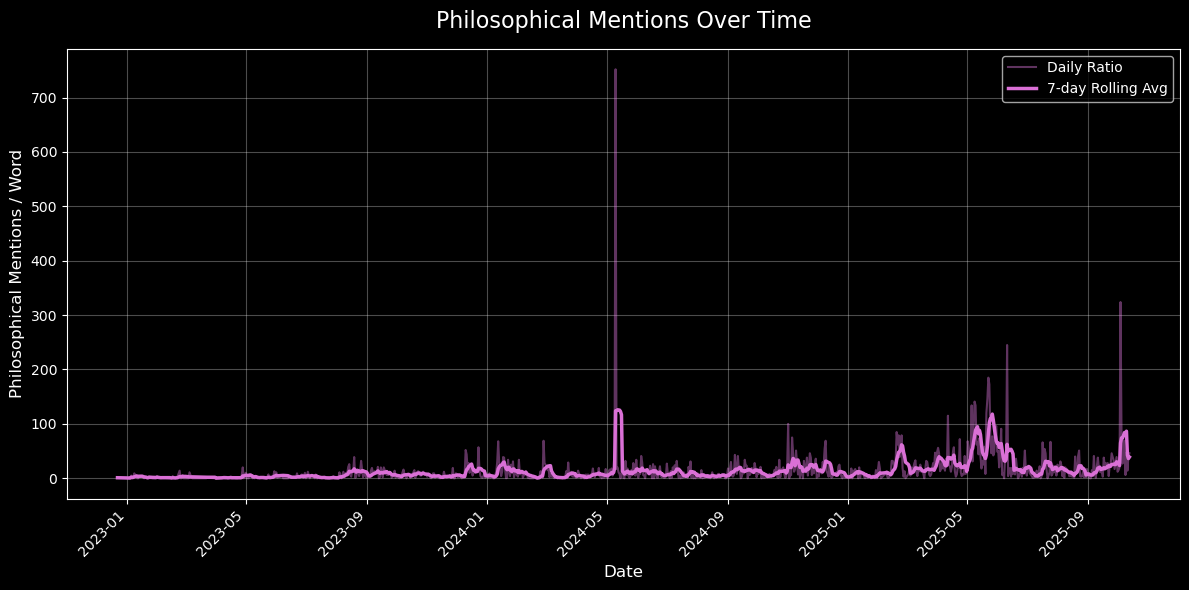

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json

# --- Load data ---
api = ChatGPTConversation("./../assets/conversations.json")
df = api.get_dataframe().copy()

# Filter only user messages
df = df[df["role"] == "user"]
df = df[df["text"].notna()]

# --- Philosophical vocabulary ---
philosophy_words = [
    # 🧠 Core philosophical domains
    "philosophy","philosophical","metaphysics","ontology","epistemology","ethics","aesthetics",
    "logic","reason","rationality","truth","knowledge","belief","wisdom","virtue","morality",
    "good","evil","justice","freedom","fate","determinism","free will","essence","existence",

    # 🧩 Philosophical schools and movements
    "stoicism","existentialism","nihilism","absurdism","idealism","realism","materialism",
    "dualism","monism","phenomenology","structuralism","postmodernism","rationalism",
    "empiricism","skepticism","utilitarianism","humanism","pragmatism","positivism",
    "relativism","objectivism","deconstruction",

    # 🧙 Thinkers
    "plato","aristotle","descartes","kant","nietzsche","heidegger","socrates","locke","hume",
    "marx","camus","sartre","spinoza","hannah arendt","foucault","deleuze","derrida","wittgenstein",
    "zizek","simone de beauvoir","pythagoras","epicurus","heraclitus","aquinas","confucius","laozi",

    # 🌀 Abstract / conceptual terms
    "being","becoming","reality","essence","mind","soul","spirit","idea","form","meaning",
    "purpose","absurd","void","nothingness","truth","illusion","rational","moral","ethical",
    "dialectic","system","transcendence","consciousness","reasoning", "ontological", "pertubation", "visceral"
]

# Optional: Load custom terms from file
try:
    with open("./assets/philosophy.json") as f:
        philosophy_words += json.load(f)
except FileNotFoundError:
    pass

# --- Regex compile ---
pattern = re.compile(r"\b(" + "|".join(map(re.escape, philosophy_words)) + r")\b", re.IGNORECASE)

# --- Convert timestamps ---
df["date"] = pd.to_datetime(df["create_time"], unit="s", errors="coerce")
df = df.dropna(subset=["date"])

# --- Count philosophical terms per message ---
df["philo_count"] = df["text"].apply(lambda x: len(pattern.findall(x)))
df["word_count"] = df["text"].apply(lambda x: len(re.findall(r"\w+", x)))

# --- Aggregate per day ---
daily = df.groupby(df["date"].dt.date).agg(
    philo_mentions=("philo_count", "sum"),
    total_words=("word_count", "sum")
).reset_index()

# --- Compute normalized ratio ---
daily["philosophy_ratio"] = daily["philo_mentions"]
daily["philosophy_ratio"] = daily["philosophy_ratio"].fillna(0)

# --- Smooth 7-day rolling mean ---
daily["philosophy_smooth"] = daily["philosophy_ratio"].rolling(window=7, min_periods=1).mean()

# --- Visualization ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    daily["date"], daily["philosophy_ratio"],
    color="violet", alpha=0.4, linewidth=1.5, label="Daily Ratio"
)
ax.plot(
    daily["date"], daily["philosophy_smooth"],
    color="orchid", linewidth=2.5, label="7-day Rolling Avg"
)

ax.set_title("Philosophical Mentions Over Time", fontsize=16, pad=15)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Philosophical Mentions", fontsize=12)
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume you have these daily DataFrames with ["date", "<category>_ratio"]
# daily_nerd, daily_reflect, daily_philosophy, daily_profane

# --- Merge them on date ---
df_all = pd.DataFrame()
df_all["date"] = pd.to_datetime(daily_nerd["date"])
df_all["nerdiness"] = daily_nerd.set_index("date")["nerdiness_ratio"]
df_all["reflection"] = daily_reflect.set_index("date")["reflection_ratio"]
df_all["philosophy"] = daily_philosophy.set_index("date")["philosophy_ratio"]
df_all["profanity"] = daily_profane.set_index("date")["profanity_ratio"]

df_all = df_all.fillna(0)

# --- Normalize so each day's total = 1.0 ---
df_norm = df_all.copy()
category_cols = ["nerdiness", "reflection", "philosophy", "profanity"]
df_norm[category_cols] = df_all[category_cols].div(df_all[category_cols].sum(axis=1), axis=0).fillna(0)

# --- Visualization ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#3EC1D3", "#F6F7D7", "#FF9A00", "#FF165D"]  # optional: pastel to vivid gradient
ax.stackplot(
    df_norm["date"],
    [df_norm[c] for c in category_cols],
    labels=[c.capitalize() for c in category_cols],
    colors=colors,
    alpha=0.9
)

ax.set_title("Semantic Composition Over Time 🌈🧠", fontsize=16, pad=15)
ax.set_xlabel("Date")
ax.set_ylabel("Relative Share of Topics (100%)")
ax.legend(loc="upper left", fontsize=10, frameon=False)
ax.grid(alpha=0.2)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

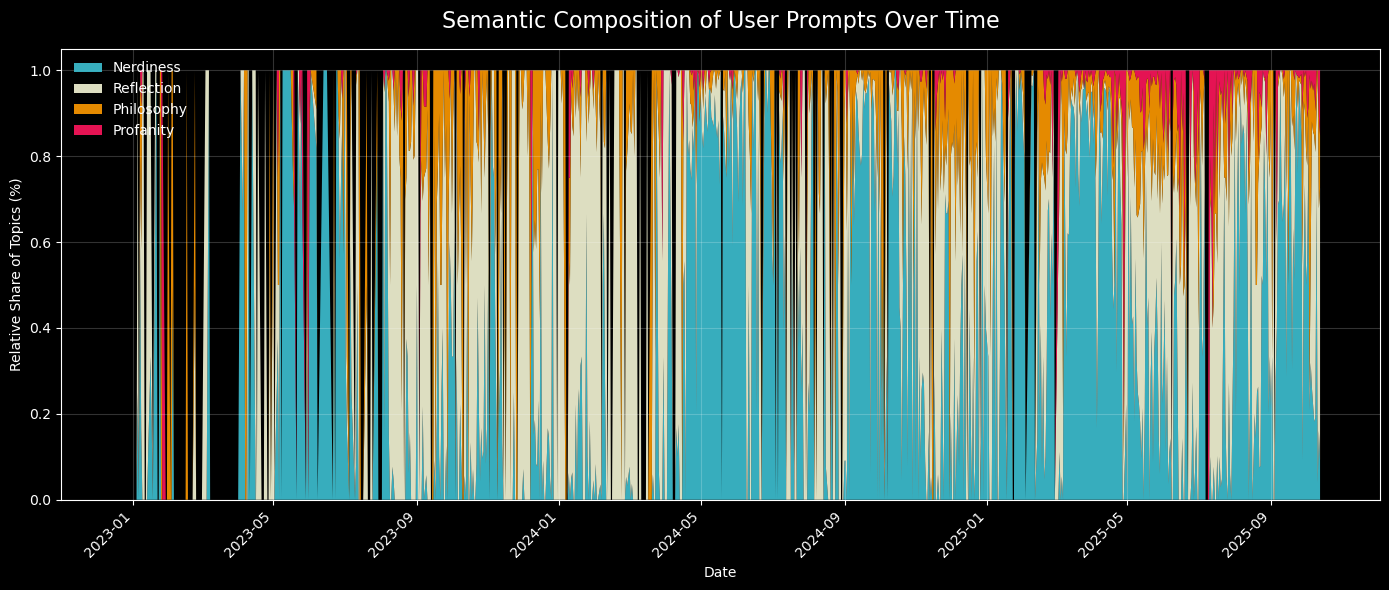

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from pathlib import Path

# -------------------------
# 1️⃣ Load conversation messages
from services.Conversation import ChatGPTConversation  # your dataframe-based API

api = ChatGPTConversation(Path("./../assets/conversations.json"))
df_messages = api.get_dataframe()

# Filter only user messages
df_messages = df_messages[df_messages["role"] == "user"]
df_messages = df_messages[df_messages["text"].notna()]

# Convert timestamps to dates
df_messages["date"] = pd.to_datetime(df_messages["create_time"], unit="s", errors="coerce")
df_messages = df_messages.dropna(subset=["date"])

# -------------------------
# 2️⃣ Load word lists for categories

def load_words(file_path: Path, fallback: list = None):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return json.load(f)
    except FileNotFoundError:
        return fallback or []

# Nerdy / Frontend
nerdy_words = load_words(Path("./assets/nerdy.json"), fallback=[
    "code","programming","debug","terminal","bash","script","cli","react","typescript","javascript","html","css","nextjs"
])

# Reflection / Psychology / Mental Health
reflect_words = load_words(Path("./assets/reflect.json"), fallback=[
    "mind","thought","feel","emotion","reflect","therapy","mental","psychology","anxiety","stress","self","cognition","consciousness"
])

# Philosophy / Ethics / Morality
philosophy_words = load_words(Path("./assets/philosophy.json"), fallback=[
    "ethics","morality","existential","philosophy","virtue","duty","justice","reason","logic","metaphysics","knowledge"
])

# Profanity / Inappropriate
profane_words = load_words(Path("./assets/profane.json"), fallback=[
    "fuck","shit","bitch","damn","ass","crap","idiot","douche"
])

# Compile regexes
category_patterns = {
    "nerdiness": re.compile(r"\b(" + "|".join(map(re.escape, nerdy_words)) + r")\b", re.IGNORECASE),
    "reflection": re.compile(r"\b(" + "|".join(map(re.escape, reflect_words)) + r")\b", re.IGNORECASE),
    "philosophy": re.compile(r"\b(" + "|".join(map(re.escape, philosophy_words)) + r")\b", re.IGNORECASE),
    "profanity": re.compile(r"\b(" + "|".join(map(re.escape, profane_words)) + r")\b", re.IGNORECASE),
}

# -------------------------
# 3️⃣ Count words per message
for cat, pattern in category_patterns.items():
    df_messages[cat] = df_messages["text"].apply(lambda x: len(pattern.findall(x)))

# Also count total words per message for normalization
df_messages["total_words"] = df_messages["text"].apply(lambda x: len(re.findall(r"\w+", x)))

# -------------------------
# 4️⃣ Aggregate per day
agg_cols = list(category_patterns.keys()) + ["total_words"]
daily = df_messages.groupby(df_messages["date"].dt.date)[agg_cols].sum().reset_index()

# Compute relative ratios (category / total words per day)
for cat in category_patterns.keys():
    daily[f"{cat}_ratio"] = daily[cat] / daily["total_words"]

# -------------------------
# 5️⃣ Normalize stack to sum 1.0 per day
ratio_cols = [f"{c}_ratio" for c in category_patterns.keys()]
daily[ratio_cols] = daily[ratio_cols].div(daily[ratio_cols].sum(axis=1), axis=0).fillna(0)

# -------------------------
# 6️⃣ Visualization (stacked area)
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(14, 6))

colors = ["#3EC1D3", "#F6F7D7", "#FF9A00", "#FF165D"]  # nerd, reflect, philosophy, profanity
ax.stackplot(
    daily["date"],
    [daily[c] for c in ratio_cols],
    labels=[c.replace("_ratio","").capitalize() for c in ratio_cols],
    colors=colors,
    alpha=0.9
)

ax.set_title("Semantic Composition of User Prompts Over Time", fontsize=16, pad=15)
ax.set_xlabel("Date")
ax.set_ylabel("Relative Share of Topics (%)")
ax.legend(loc="upper left", fontsize=10, frameon=False)
ax.grid(alpha=0.2)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

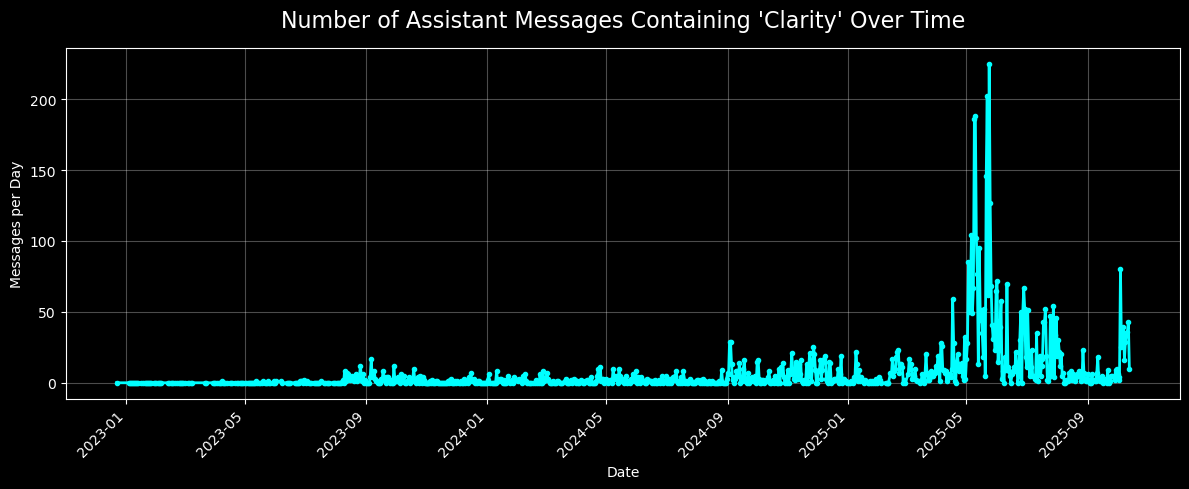

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Load data ---
api = ChatGPTConversation("./../assets/conversations.json")
df = api.get_dataframe().copy()

# Filter only assistant messages
df = df[df["role"] == "assistant"]
df = df[df["text"].notna()]

# --- Compile regex for "clarity" ---
pattern = re.compile(r"\bclarity\b", re.IGNORECASE)

# --- Convert timestamps ---
df["date"] = pd.to_datetime(df["create_time"], unit="s", errors="coerce")
df = df.dropna(subset=["date"])

# --- Flag messages that contain at least one 'clarity' ---
df["has_clarity"] = df["text"].apply(lambda x: bool(pattern.search(x)))

# --- Aggregate per day: count messages containing clarity ---
daily_clarity = (
    df.groupby(df["date"].dt.date)["has_clarity"]
    .sum()
    .reset_index(name="clarity_message_count")
)

# --- Visualization ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(
    daily_clarity["date"], daily_clarity["clarity_message_count"],
    color="cyan", linewidth=2.0, marker='o', markersize=3
)
ax.set_title("Number of Assistant Messages Containing 'Clarity' Over Time", fontsize=16, pad=15)
ax.set_xlabel("Date")
ax.set_ylabel("Messages per Day")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()